In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix


import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [3]:
covid = pd.read_csv("CovidData.csv")

In [4]:
covid.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
#数据清洗


covid = covid.loc[(covid.CLASIFFICATION_FINAL < 4)]
covid = covid.loc[(covid.SEX == 1) | (covid.SEX == 2)]
covid = covid.loc[(covid.USMER == 1) | (covid.USMER == 2)]
covid = covid.loc[(covid.PATIENT_TYPE == 1) | (covid.PATIENT_TYPE == 2)]
covid = covid.loc[(covid.PNEUMONIA == 1) | (covid.PNEUMONIA == 2)]
covid = covid.loc[(covid.DIABETES == 1) | (covid.DIABETES == 2)]
covid = covid.loc[(covid.COPD == 1) | (covid.COPD == 2)]
covid = covid.loc[(covid.ASTHMA == 1) | (covid.ASTHMA == 2)]
covid = covid.loc[(covid.INMSUPR == 1) | (covid.INMSUPR == 2)]
covid = covid.loc[(covid.HIPERTENSION == 1) | (covid.HIPERTENSION == 2)]
covid = covid.loc[(covid.OTHER_DISEASE == 1) | (covid.OTHER_DISEASE == 2)]
covid = covid.loc[(covid.CARDIOVASCULAR == 1) | (covid.CARDIOVASCULAR == 2)]
covid = covid.loc[(covid.OBESITY == 1) | (covid.OBESITY == 2)]
covid = covid.loc[(covid.RENAL_CHRONIC == 1) | (covid.RENAL_CHRONIC == 2)]
covid = covid.loc[(covid.TOBACCO == 1) | (covid.TOBACCO == 2)]



In [6]:
# ONE HOT


covid.SEX = covid.SEX.apply(lambda x: x if x == 1 else 0)  
covid.USMER = covid.USMER.apply(lambda x: x if x == 1 else 0)                     # no = 0, yes = 1
covid.PATIENT_TYPE = covid.PATIENT_TYPE.apply(lambda x: 0 if x == 1 else 1)     
covid.PNEUMONIA = covid.PNEUMONIA.apply(lambda x: x if x == 1 else 0)           
covid.DIABETES = covid.DIABETES.apply(lambda x: x if x == 1 else 0)             
covid.COPD = covid.COPD.apply(lambda x: x if x == 1 else 0)                     
covid.ASTHMA = covid.ASTHMA.apply(lambda x: x if x == 1 else 0)                 
covid.INMSUPR = covid.INMSUPR.apply(lambda x: x if x == 1 else 0)               
covid.HIPERTENSION = covid.HIPERTENSION.apply(lambda x: x if x == 1 else 0)     
covid.OTHER_DISEASE = covid.OTHER_DISEASE.apply(lambda x: x if x == 1 else -0)  
covid.CARDIOVASCULAR = covid.CARDIOVASCULAR.apply(lambda x: x if x == 1 else 0) 
covid.OBESITY = covid.OBESITY.apply(lambda x: x if x == 1 else 0)               
covid.RENAL_CHRONIC = covid.RENAL_CHRONIC.apply(lambda x: x if x == 1 else 0)   
covid.TOBACCO = covid.TOBACCO.apply(lambda x: x if x == 1 else 0)               
covid.DATE_DIED = covid.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1)
covid.PREGNANT = covid.PREGNANT.apply(lambda x: x if x == 1 else 0)           
covid.INTUBED = covid.INTUBED.apply(lambda x: x if x == 1 else 0)                   
covid.ICU = covid.ICU.apply(lambda x: x if x == 1 else 0)

In [7]:
covid['AT_RISK'] = covid['DATE_DIED'] + covid['INTUBED'] + covid['ICU']
covid.AT_RISK = covid.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 

# Drop a few columns which are intuitively not longer useful
covid.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED'], inplace=True)

In [8]:
print(covid.info())

<class 'pandas.core.frame.DataFrame'>
Index: 388878 entries, 0 to 1047937
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   USMER           388878 non-null  int64
 1   MEDICAL_UNIT    388878 non-null  int64
 2   SEX             388878 non-null  int64
 3   PATIENT_TYPE    388878 non-null  int64
 4   PNEUMONIA       388878 non-null  int64
 5   AGE             388878 non-null  int64
 6   PREGNANT        388878 non-null  int64
 7   DIABETES        388878 non-null  int64
 8   COPD            388878 non-null  int64
 9   ASTHMA          388878 non-null  int64
 10  INMSUPR         388878 non-null  int64
 11  HIPERTENSION    388878 non-null  int64
 12  OTHER_DISEASE   388878 non-null  int64
 13  CARDIOVASCULAR  388878 non-null  int64
 14  OBESITY         388878 non-null  int64
 15  RENAL_CHRONIC   388878 non-null  int64
 16  TOBACCO         388878 non-null  int64
 17  AT_RISK         388878 non-null  int64
dtypes: int64

In [9]:
covid.describe

<bound method NDFrame.describe of          USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE  PNEUMONIA  AGE  PREGNANT  \
0            0             1    1             0          1   65         0   
2            0             1    0             1          0   55         0   
4            0             1    0             0          0   68         0   
5            0             1    1             1          1   40         0   
6            0             1    1             0          0   64         0   
...        ...           ...  ...           ...        ...  ...       ...   
1047933      1            13    1             1          0   77         0   
1047934      1            13    1             0          0   55         0   
1047935      1            13    0             0          0   70         0   
1047936      0            13    0             0          0   32         0   
1047937      0            13    1             0          0   30         0   

         DIABETES  COPD  ASTHMA  INMSUPR 

In [14]:
#train(90%), validation(5%) and test(5%)
train, validation = train_test_split(covid, test_size=0.1, shuffle=True)
validation, test = train_test_split(validation, test_size=0.5, shuffle=True)

validation_y = validation.AT_RISK.to_numpy()
validation_x = validation.drop(columns = ['AT_RISK']).to_numpy()

test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

In [15]:
#F1评价指标


def get_Fmeasure(prediction, labels):

    # Compares the prediction of each object to its label
    true_positive = np.sum((prediction + labels) == 2)
    false_positive = np.sum((labels - prediction) == -1)
    false_negative = np.sum((prediction - labels) == -1)
    positive = np.count_nonzero(labels == 1)
    negative = len(labels)-positive

    # Calculate F-measure
    accuracy = 100*np.sum(prediction == labels)/len(labels)
    recall = true_positive / (true_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    eval = 2*(precision * recall) / (precision + recall)
    return eval



In [16]:
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()



heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [5, 7, 11, 13, 17]
dt_fmeasures = {}
dt_best_result = 0


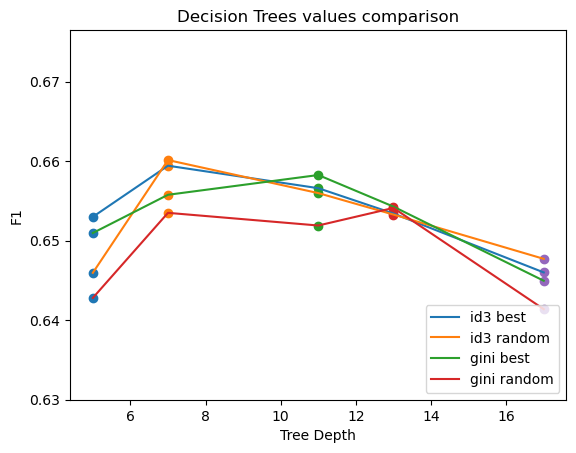

In [20]:
for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(validation_x)

        # calculate F-measures and save best model
        dt_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
        if dt_fmeasures[d][i] > dt_best_result:
            dt_best_result = dt_fmeasures[d][i]
            dt_best_model = dt_classifier
        i=i+1
        
    

l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

# create line for each of the four models
plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F1')
plt.ylim(0.630, 0.6765)
plt.show()



In [21]:
params = dt_best_model.get_params()
print('best result for: heuristic = %s, splitter = %s, max depth = %d, F1 = %f' % (params['criterion'], params['splitter'], params['max_depth'], dt_best_result))



best result for: heuristic = entropy, splitter = random, max depth = 7, F1 = 0.660153


In [22]:
dt_pred = dt_best_model.predict(test_x)

In [24]:
final_fmeasures = {}
final_fmeasures['decision tree'] = get_Fmeasure(dt_pred, test_y)

In [26]:
from sklearn.metrics import classification_report
print('\n', classification_report(test_y, dt_pred))


               precision    recall  f1-score   support

           0       0.99      0.84      0.91     16368
           1       0.52      0.95      0.67      3076

    accuracy                           0.86     19444
   macro avg       0.76      0.89      0.79     19444
weighted avg       0.91      0.86      0.87     19444



In [35]:
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix

In [48]:
test_y = np.array(test_y)
dt_pred = np.array(dt_pred)
y_test = test_y.copy()
y_pred = dt_pred.copy()
c_matrix_tree = confusion_matrix(y_test, y_pred)
print(c_matrix_tree) #打印出来看看


[[13715  2653]
 [  164  2912]]


In [49]:
from sklearn.metrics import confusion_matrix    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库
import numpy as np
import tensorflow as tf

def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

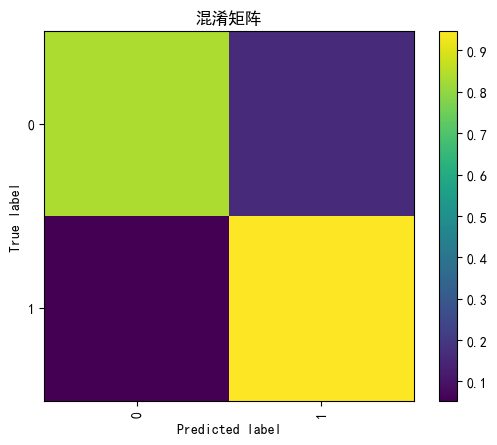

In [53]:
    plot_confusion_matrix(c_matrix_tree, [0,1], "混淆矩阵")
    plt.show()